In [2]:
import dataset
import run_training
import importlib
import analysis as an
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch_geometric.loader as geomloader
from trainer import eval
from st_gat import STGAT

In [ ]:
# load the model file
cfg = run_training.Config.overfit_config()
np.random.seed(cfg.seed)
th.manual_seed(cfg.seed)

model = STGAT(N_nodes= cfg['N_stations'], cfg = cfg, **cfg.__dict__)
model.load_state_dict(th.load(cfg.model_path(epoch = 39)))

data = dataset.BikeGraphDataset(cfg)
train, val, test = data.get_day_splits(shuffle=False)
train_loader = geomloader.DataLoader(train, batch_size=cfg['batch_size'], shuffle=False)

_, _, y_preds, y_demand_preds, y_truths = eval(model, train, train_loader, cfg)

/tmp/ipykernel_34486/740172066.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load(cfg.model_path(epoch = 39)))
/mnt/vol2/BikeSharePrediction/s

ValueError: not enough values to unpack (expected 6, got 5)

/tmp/ipykernel_12026/2714381576.py:21: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(y_truth_in_station[times], label=['truth in', 'truth out'])


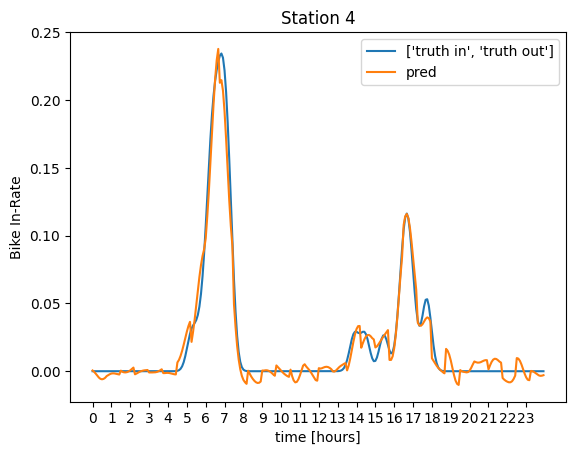

In [ ]:
def reshape_data4viz(y, cfg):
    """
        Reshape the data for visualization.
        Given
        y_truths: (N_batches, batch_size * N_nodes, 2 * N_preds)
        reshape and transform into (N_batches * batch_size, N_nodes, 2) in order to allow concatenating data for contiguous segments (e.g. full days).
    """
    N_batches = y.size(0)
    y_squashed = y.view(N_batches * cfg.batch_size, cfg.N_stations, cfg.N_predictions, 2)
    # swap axes such that the predictions are the axis 1
    y_subsampled = y_squashed[::cfg['N_predictions'], :, :, :].swapaxes(1, 2).reshape(-1, cfg.N_stations, 2)
    return y_subsampled

def plot_station(y_truths, y_preds, i_station, cfg):
    y_truths_reshaped = reshape_data4viz(y_truths,cfg)
    y_preds_reshaped = reshape_data4viz(y_preds,cfg)
    
    y_truth_in_station = y_truths_reshaped[:, i_station, 0]
    y_pred_in_station = y_preds_reshaped[:, i_station, 0]
    times = np.arange(0, 288)
    plt.plot(y_truth_in_station[times], label='truth in')
    plt.plot(y_pred_in_station[times], label='pred')
    plt.legend()
    plt.gca().set(title='Station {}'.format(i_station), xlabel='time [hours]', ylabel='Bike In-Rate')
    plt.xticks(times[::12], times[::12] * cfg['subsample_minutes'] // 60)
    return plt.show()

plot_station(y_truths, y_preds, 4, cfg)

In [ ]:
np.linalg.norm(y_preds - y_truths) / np.linalg.norm(y_truths)

np.float32(0.12928247)

[Text(0.5, 1.0, 'Station 66'),
 Text(0.5, 0, 'time [minutes]'),
 Text(0, 0.5, 'Bike In-Rate')]

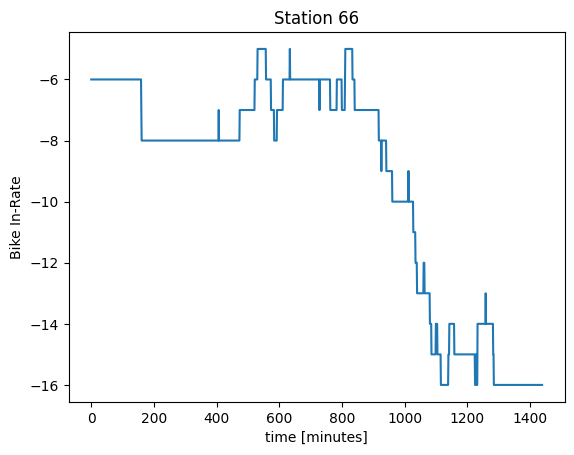

In [ ]:
import analysis as an
bike_data = an.BikeShareData.load(month='05', year='2024')
i_station = 66
month_minutes = 30 * 24 * 60
in_bikes_month = bike_data.in_bikes[i_station, :month_minutes]
out_bikes_month = bike_data.out_bikes[i_station, :month_minutes]
cum_bikes_month = np.cumsum(in_bikes_month) - np.cumsum(out_bikes_month)
plt.plot(cum_bikes_month[24*60: 2*24*60])
plt.gca().set(title='Station {}'.format(i_station), xlabel='time [minutes]', ylabel='Bike In-Rate')


In [ ]:
# compute daily mins and maxes
# reshape the data into single days
# mark the maxes and mins in the plot
num_days = 5
cum_bikes_month = (np.cumsum(in_bikes_month) - np.cumsum(out_bikes_month))[0:24*60*num_days]
reshaped = cum_bikes_month.reshape(-1, 24*60)
daily_maxes = np.max(reshaped, axis=1)
max_inds = np.argmax(reshaped, axis=1)
daily_mins = np.min(reshaped, axis=1)
min_inds = np.argmin(reshaped, axis=1)
plt.plot(cum_bikes_month)
day_starts = np.arange(0, num_days) * 24 * 60
day_ends = np.arange(1, 1+num_days) * 24 * 60
daily_maxes_arr = np.zeros_like(cum_bikes_month)
daily_mins_arr = np.zeros_like(cum_bikes_month)

tolerance = 2

for i, (day_start, day_end) in enumerate(zip(day_starts, day_ends)):
    daily_maxes_arr[day_start:day_end] = daily_maxes[i] - tolerance
    daily_mins_arr[day_start:day_end] = daily_mins[i] + tolerance

plt.plot(daily_maxes_arr, label='daily max')
plt.plot(daily_mins_arr, label='daily min')

plt.legend()
plt.gca().set(title='Station {}'.format(i_station), xlabel='time [minutes]', ylabel='Cumulative Number of Bikes')

NameError: name 'np' is not defined

In [ ]:
at_min_mask = (cum_bikes_month <= daily_mins_arr + 2)
at_max_mask = (cum_bikes_month >= daily_maxes_arr - 2)